# Detecting physical microstate pairs for microscopic pKas

My goal is to indentify physical or unphysical microstate pairs, from a list of enumerated microstates of SAMPL6 molecules.  

A physical microstate pairs is a pair of microstates that can convert to each other by protonation or deprotonation of only one titratable group, while protonation state of the other groups stay constant.  
Total charge difference between physical microstate pairs should be 1.  
Resonance structures or geometric isomers are not considered unique microstates.
A microscopic pKa can be calculated for physical microstate pairs.

If converting a microstate to another requiers protonotation/deprotonation of one titratable group and a shift of  a proton position, then this pair of microstates won't constitute a physical microscopic pKa.

TO-DO:
1. Check if total charge difference is 1 or -1
2. Find maximum common substructure (MCSS)
3. Check that there is only 1 unique MCSS match
4. Check that number of heavy atoms in MCSS match is equal to the number of heavy atoms in target molecule
5. Check that equivalent heavy atoms have equivalent number of bound hydrogens. A physical micorstate pair can have only one heavy atom that has different number of bound hydrogens.

Summary of this method:  
1) Label heavy atoms of both structures with an index (order of these indexes is random )  
2) When doing the MCSS match with molecules without explicit hydrogens, create a dictionary that matches pattern and target heavy atom labels.  
3) Using the dictionary, iterate through equivalent heavy atoms of the original two molecules and compare bound hydrogen counts.  
4) Check how many heavy atom positions are different in hydrogen count.  

In [1]:
import pandas as pd
import numpy as np
from openeye import oechem, oedepict
import oenotebook as oenb
from IPython.display import HTML, display
from base64 import b64encode

In [2]:
def get_labeled_mol(smiles, label='heavy'):
    """
    returns an OEMol with heavy atoms labeled with a specific indice
    """
    mol = oechem.OEMol()
    if not oechem.OESmilesToMol(mol, smiles):
        print("Couldn't parse smiles (%s) returning None" % smiles)
        return None
    
    for idx, a in enumerate(mol.GetAtomIter(oechem.OEIsHeavy())):
        a.SetData('heavy', idx+1)
    
    return mol


class LabelDepictionWithHeavyAtomLabels(oedepict.OEDisplayAtomPropBase):
    """
    Necessary class for display_heavy_atom_labels function.
    """
    def __init__(self):
        oedepict.OEDisplayAtomPropBase.__init__(self)

    def __call__(self, atom):
        if atom.GetData("heavy") > 0 :
            return str(atom.GetData("heavy"))
        return ""

    def CreateCopy(self):
        # __disown__ is required to allow C++ to take
        # ownership of this object and its memory
        copy = LabelDepictionWithHeavyAtomLabels()
        return copy.__disown__()


def display_heavy_atom_labels(mol):
    """
    Creates HTML depiction of mol with custom heavy atom labels (atom.GetData("Heavy")).
    """
    oedepict.OEPrepareDepiction(mol)
    width, height = 300, 300
    img = oedepict.OEImage(width, height)

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    atomlabel = LabelDepictionWithHeavyAtomLabels()
    opts.SetAtomPropertyFunctor(atomlabel)
    opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkGreen))

    disp = oedepict.OE2DMolDisplay(mol, opts)
    oedepict.OERenderMolecule(img, disp)
    
    return oenb.draw_oeimage_to_img_tag(img)

def display_atom_indices(mol):
    """
    Creates HTML depiction of mol with atom indices.
    """
    oedepict.OEPrepareDepiction(mol)
    width, height = 300, 300
    img = oedepict.OEImage(width, height)

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
    opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkBlue))

    disp = oedepict.OE2DMolDisplay(mol, opts)
    oedepict.OERenderMolecule(img, disp)
    
    return oenb.draw_oeimage_to_img_tag(img)

def get_total_charge(mol):
    """
    Calculates total formal charge of a molecule.
    
    Input
    mol: oechem.OEMol() object
    """
    total_charge = 0
    for a in mol.GetAtomIter():
        total_charge += a.GetFormalCharge()
    return total_charge

def compare_total_charge(mol1, mol2):
    """
    Compares total formal charge of two SMILES strings.
    Returns True of they have equal formal charge.
    """
    total_charge1 = get_total_charge(mol1)
    total_charge2 = get_total_charge(mol2)
    if total_charge1 == total_charge2:
        return True
    else:
        return False
    
def calculate_total_charge_difference(mol1, mol2):
    charge_difference = get_total_charge(mol1) - get_total_charge(mol2)
    return charge_difference
    
def draw_subsearch_highlights(mol, subsearch, width=300., height=300.):
    """
    Creates 2D HTML depiction of a molecule with substructure highlighted.
    Subsearch attribute must be substructure or mcss object.
    """
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)

    mol = oechem.OEGraphMol(mol)
    oedepict.OEPrepareDepiction(mol)
    img = oedepict.OEImage(width, height)
    hstyle = oedepict.OEHighlightByBallAndStick(oechem.OEBlueTint)

    disp = oedepict.OE2DMolDisplay(mol, opts)
    unique = True
    for match in subsearch.Match(mol, unique):
        oedepict.OEAddHighlighting(disp, hstyle, match)
    
    oedepict.OERenderMolecule(img, disp)
    return oenb.draw_oeimage_to_img_tag(img)

def count_heavy_atoms(mol):
    """
    Returns number of heavy atoms in a molecule.
    """
    heavy_atom_count = 0
    for idx, atom in enumerate(mol.GetAtomIter()):
        heavy_atom_count = idx + 1
        #print(atom, atom.GetData()) # Target mol has labelled heavy atoms
    return heavy_atom_count

def get_total_hydrogen_count(mol):
    """
    Calculates total number of hydrogens in a structure.
    """
    hydrogen_count = 0
    
    for idx, atom in enumerate(mol.GetAtomIter()):
        hydrogen_count += atom.GetTotalHCount()
    
    return hydrogen_count

def get_mcss(pattern, target):
    """
    Finds maximum common substructure based on atomic number criteria 
    
    Returns the match as a mol object and a dictionary that maps pattern heavy atom labels to target labels .
    
    MCSS should result in only 1 match.
    """
    atomexpr = oechem.OEExprOpts_AtomicNumber
    bondexpr = oechem.OEExprOpts_EqSingleDouble # single or double bonds are considered identical

    #bondexpr = oechem.OEExprOpts_DefaultBonds
    #atomexpr = oechem.OEExprOpts_DefaultAtoms 
    
    # create maximum common substructure object
    mcss = oechem.OEMCSSearch(pattern, atomexpr, bondexpr, oechem.OEMCSType_Exhaustive)
    
    # set scoring function
    #mcss.SetMCSFunc(oechem.OEMCSMaxAtoms())
    mcss.SetMCSFunc(oechem.OEMCSMaxAtomsCompleteCycles())

    # ignore matches smaller than 6 atoms
    mcss.SetMinAtoms(6)
    unique = True
    
    # create a dictionary that maps pattern heavy atom labels to target labels
    label_dict = {}

    # loop over matches
    for i, match in enumerate(mcss.Match(target, unique)):
        count = i + 1
        print ("Match %d:" % (count))
        
        print ("pattern atoms:", end=" ")
        for ma in match.GetAtoms():
            print (ma.pattern.GetIdx(), end=" ")
        print ("\ntarget atoms: ", end=" ")
        for ma in match.GetAtoms():
            print (ma.target.GetIdx(), end=" ")
        print()
        
        print ("\npattern heavy atom labels:", end=" ")
        for ma in match.GetAtoms():
            print (ma.pattern.GetData("heavy"), end=" ")
        print ("\ntarget heavy atom labels: ", end=" ")
        for ma in match.GetAtoms():
            print (ma.target.GetData("heavy"), end=" ")
        print()
        
        # record matching pattern and target labels in a dictionary
        for ma in match.GetAtoms():
            label_dict[ma.pattern.GetData("heavy")] = ma.target.GetData("heavy")

        # create match subgraph
        m = oechem.OEGraphMol()
        oechem.OESubsetMol(m, match, True)

        print ("\nmatch smiles =", oechem.OEMolToSmiles(m))

    # check if there is only single match
    if (count != 1):
        print("Warning! There is multiple matches.")
    else:
        print("Exactly one match.")
        
    return m, label_dict, mcss

def get_labelled_heavy_atom_Hcount(mol, heavy_atom_label, data_section = "heavy"):
    """
    finds the heavy atom with the same label in a molecule and returns its H-count
    """
    query_label = heavy_atom_label
    for i, atom in enumerate(mol.GetAtomIter()):
        pattern_label = atom.GetData(data_section)
        if pattern_label == query_label:
            Hcount = atom.GetTotalHCount()
            return Hcount
    # if not found
    return np.NaN

def check_how_many_heavy_atoms_changed_protonation_state(pattern, target, label_dict):
    """
    Returns the number of labeled heavy atoms that have different number of bound hydrogens between
    two proposed microstates of the same molecule.
    """
    
    # create numpy arrays to store heavy atom hydrogen counts
    pattern_HCount_array = np.zeros(count_heavy_atoms(pattern))
    target_HCount_array = np.zeros(count_heavy_atoms(target))
    #print("Pattern number of heavy atoms: ", count_heavy_atoms(pattern))
    #print("Target number of heavy atoms:  ", count_heavy_atoms(target))
    #print("label_dict:")
    #print(label_dict)
    #print("len pattern_HCount_array: ", len(pattern_HCount_array))
    #print("len target_HCount_array: ", len(target_HCount_array))

    # iterate over label dictionary to and populate Hcount arrays
    for ii, (key, value) in enumerate(label_dict.items()):
        #print(ii, key, value)
        p_label = key
        t_label = value

        # find the heavy atom with the same label in pattern molecule and get H-count
        Hcount = get_labelled_heavy_atom_Hcount(pattern, p_label)
        #print("ii: ", ii)
        pattern_HCount_array[ii] = Hcount

        # find the heavy atom with the same label in target molecule and get H-count
        Hcount = get_labelled_heavy_atom_Hcount(target, t_label)
        target_HCount_array[ii] = Hcount

    print("Pattern Hcount: ", pattern_HCount_array)
    print("Target Hcount: ", target_HCount_array)

    # calculate difference of 2 arrays
    Hcount_difference_array = np.subtract(pattern_HCount_array,target_HCount_array)
    print("Difference in Hcount:", Hcount_difference_array )

    # calculate the number of heavy atoms protonated or deprotonated
    prot_deprot_heavy_atom_count = 0
    for diff in Hcount_difference_array:
        if diff != 0.0:
            prot_deprot_heavy_atom_count += 1

    print("Number of heavy atoms with different number of hydrogens: ", prot_deprot_heavy_atom_count)
    return prot_deprot_heavy_atom_count

def is_physical_microstate_pair(pattern, target):
    
    # Compare number of heavy atoms
    difference_of_heavy_atom_number = count_heavy_atoms(pattern) - count_heavy_atoms(target)
    if difference_of_heavy_atom_number != 0:
        print("Not microstates of the same molecule.")
        return False
    
    # Compare total charge
    total_charge_difference = calculate_total_charge_difference(pattern, target)
    if abs(total_charge_difference) != 1:
        print("Not a physical microstate pair. Total charge difference is ", total_charge_difference)
        return False
    
    # Find MCSS of two molecules and find equivalent heavy atoms
    label_dictionary = {}
    m, label_dictionary, mcss = get_mcss(pattern, target)
    #print("Length of label_dictionary: ", len(label_dictionary) )
    
    # how many heavy atoms have different protonation state?
    prot_deprot_heavy_atom_count = check_how_many_heavy_atoms_changed_protonation_state(pattern, target, label_dictionary)
    if prot_deprot_heavy_atom_count == 1 :
        print("These two microstates create a physical microscopic pKa pair.")
        return True
    else:
        print("Not a physical microstate pair.")
        return False

In [3]:
# Example test cases
# a physical microscopic pKa
SM24_micro011 = "COc1ccc(cc1)c2c3c(=[NH+]CCO)[nH]cnc3oc2c4ccc(cc4)OC" # HA+
SM24_micro013 = "COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]" # A 

# not a physical microscopic pKa
SM24_micro010 = "COc1ccc(cc1)c2c3c([nH+]cnc3NCCO)oc2c4ccc(cc4)OC" # HA+
SM24_micro013 = "COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]" # A and a hydrogen shift

In [4]:
print("Total charge of micro010:", get_total_charge(get_labeled_mol(SM24_micro010)))
print("Total charge of micro011:", get_total_charge(get_labeled_mol(SM24_micro011)))
print("Total charge of micro013:", get_total_charge(get_labeled_mol(SM24_micro013)))

Total charge of micro010: 1
Total charge of micro011: 1
Total charge of micro013: 0


## Example of physical pKa microstate pairs
SM24_micro011 and SM24_micro13

In [5]:
pattern = get_labeled_mol(SM24_micro011) # HA+
target = get_labeled_mol(SM24_micro013) # A

# check if total charge difference is 1.
charge_difference = int(calculate_total_charge_difference(pattern, target))
print("Total charge difference is: ", charge_difference)
print()

# check the difference of hydrogen counts
print("Total hydrogen count of pattern: ", get_total_hydrogen_count(pattern))
print("Total hydrogen count of target: ", get_total_hydrogen_count(target))

Total charge difference is:  1

Total hydrogen count of pattern:  22
Total hydrogen count of target:  21


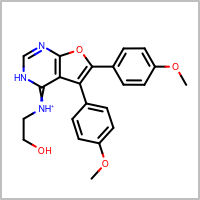

In [6]:
oenb.draw_mol(pattern)

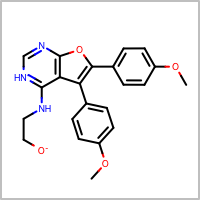

In [7]:
oenb.draw_mol(target)

### Deciding on correct MCSS settings

In [8]:
# Find MCSS
#atomexpr = oechem.OEExprOpts_DefaultAtoms 
atomexpr = oechem.OEExprOpts_AtomicNumber 
bondexpr = oechem.OEExprOpts_EqSingleDouble # single or double bonds are considered identical

# create maximum common substructure object
mcss = oechem.OEMCSSearch(pattern, atomexpr, bondexpr, oechem.OEMCSType_Exhaustive)
mcss

<oechem.OEMCSSearch; proxy of <Swig Object of type 'OEChem::OEMCSSearch *' at 0x10ff462a0> >

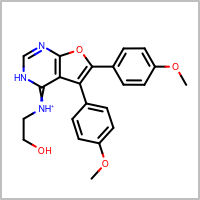

In [9]:
oenb.draw_mol(pattern)


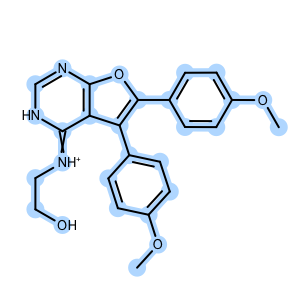

In [10]:
HTML(draw_subsearch_highlights(pattern,mcss))


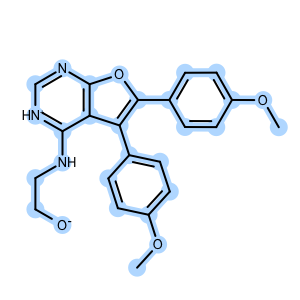

In [11]:
HTML(draw_subsearch_highlights(target,mcss)) # Highlighted regions of target shows the MCSS match


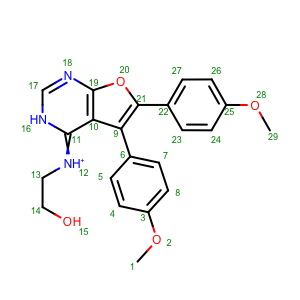

In [12]:
# Display heavy atom labels
HTML(display_heavy_atom_labels(pattern))


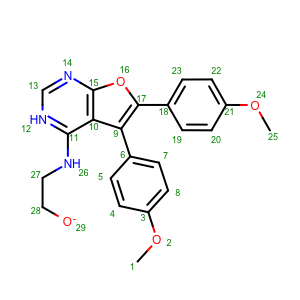

In [13]:
HTML(display_heavy_atom_labels(target))

### How to get bound hydrogen counts of pattern and target molecules using MCSS heavy atoms labels?

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 25 26 27 28 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 26 27 28 29 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

match smiles = COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]
Exactly one match.



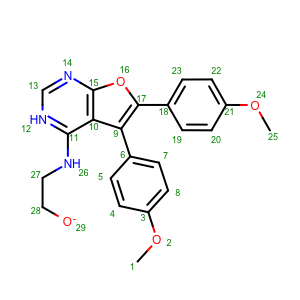

In [14]:
m, label_dict, mcss = get_mcss(pattern, target)
HTML(display_heavy_atom_labels(m)) # displays custom heavy atom labels inherited from target

Match substructure m's heavy atom labels are inherited from target molecule, not the pattern molecule.  

In [15]:
is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 25 26 27 28 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 26 27 28 29 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

match smiles = COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]
Exactly one match.
Pattern Hcount:  [ 3.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  2.  2.  1.  1.  1.  0.
  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  3.]
Target Hcount:  [ 3.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  2.  2.  0.  1.  1.  0.
  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  3.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Number of heavy atoms with different number of hydrogens:  1
These two microstates create a ph

True

## Example of unphysical pKa microstate pairs
SM24_micro010 and SM24_micro13

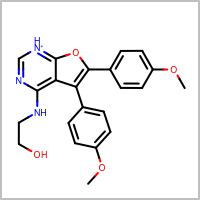

In [16]:
pattern = get_labeled_mol(SM24_micro010) # HA+
target = get_labeled_mol(SM24_micro013) # A
oenb.draw_mol(pattern)

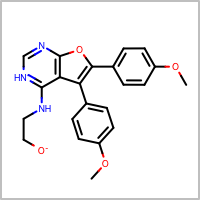

In [17]:
oenb.draw_mol(target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
target atoms:  0 1 2 3 4 5 6 7 8 9 14 13 12 11 10 25 26 27 28 15 16 17 18 19 20 21 22 23 24 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 15 14 13 12 11 26 27 28 29 16 17 18 19 20 21 22 23 24 25 

match smiles = COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]
Exactly one match.



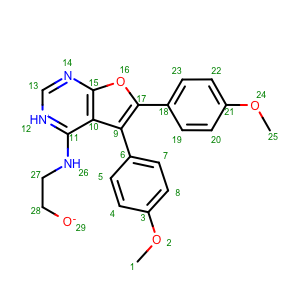

In [18]:
m, label_dict, mcss = get_mcss(pattern, target)
HTML(display_heavy_atom_labels(m)) # displays custom heavy atom labels inherited from target

Match substructure m's heavy atom labels are inherited from target molecule, not the pattern molecule.  

In [19]:
is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
target atoms:  0 1 2 3 4 5 6 7 8 9 14 13 12 11 10 25 26 27 28 15 16 17 18 19 20 21 22 23 24 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 15 14 13 12 11 26 27 28 29 16 17 18 19 20 21 22 23 24 25 

match smiles = COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]
Exactly one match.
Pattern Hcount:  [ 3.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  2.  2.
  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  3.]
Target Hcount:  [ 3.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  2.  2.
  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  3.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Number of heavy atoms with different number of hydrogens:  3
Not a physical microstate pair.


False

## Other Examples 

In [20]:
# two molecules with +2 charge difference
SM24_micro027 = "COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCC[O-]" #A-
SM24_micro011 = "COc1ccc(cc1)c2c3c(=[NH+]CCO)[nH]cnc3oc2c4ccc(cc4)OC" # H2A+
pattern = get_labeled_mol(SM24_micro027)
target = get_labeled_mol(SM24_micro011)

is_physical_microstate_pair(pattern, target)

Not a physical microstate pair. Total charge difference is  -2


False

In [21]:
# same molecule
SM24_micro027 = "COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCC[O-]" #A-
pattern = get_labeled_mol(SM24_micro027)
target = get_labeled_mol(SM24_micro027)

is_physical_microstate_pair(pattern, target)

Not a physical microstate pair. Total charge difference is  0


False

In [22]:
# not a physical microstate pair
SM02_micro008 = "c1ccc2c(c1)c(nc[nH+]2)[NH2+]c3cccc(c3)C(F)(F)F"
SM02_micro005 = "c1ccc2c(c1)c([nH+]cn2)Nc3cccc(c3)C(F)(F)F"

pattern = get_labeled_mol(SM02_micro008)
target = get_labeled_mol(SM02_micro005)

is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

match smiles = c1ccc2c(c1)c([nH+]cn2)Nc3cccc(c3)C(F)(F)F
Exactly one match.
Pattern Hcount:  [ 1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  2.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  0.]
Target Hcount:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  0.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
Number of heavy atoms with different number of hydrogens:  3
Not a physical microstate pair.


False

In [28]:
# a physical microstate pair
SM02_micro012 = "c1ccc2c(c1)c([nH+]c[nH+]2)Nc3cccc(c3)C(F)(F)F"
SM02_micro005 = "c1ccc2c(c1)c([nH+]cn2)Nc3cccc(c3)C(F)(F)F"

pattern = get_labeled_mol(SM02_micro012)
target = get_labeled_mol(SM02_micro005)

is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

match smiles = c1ccc2c(c1)c([nH+]cn2)Nc3cccc(c3)C(F)(F)F
Exactly one match.
Pattern Hcount:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  0.]
Target Hcount:  [ 1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.
  0.  0.  0.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
Number of heavy atoms with different number of hydrogens:  1
These two microstates create a physical microscopic pKa pair.


True

In [33]:
## a physical pair
SM03_micro024 = "c1ccc(cc1)Cc2[nH+][nH+]c(s2)NC(=O)c3cccs3"
SM03_micro001 = "c1ccc(cc1)Cc2[nH+]nc(s2)NC(=O)c3cccs3"

pattern = get_labeled_mol(SM03_micro024)
target = get_labeled_mol(SM03_micro001)

is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

match smiles = c1ccc(cc1)Cc2[nH+]nc(s2)NC(=O)c3cccs3
Exactly one match.
Pattern Hcount:  [ 1.  1.  1.  0.  1.  1.  2.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  1.  0.]
Target Hcount:  [ 1.  1.  1.  0.  1.  1.  2.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.
  1.  0.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Number of heavy atoms with different number of hydrogens:  1
These two microstates create a physical microscopic pKa pair.


True

In [35]:
## a physical pair
SM03_micro024 = "c1ccc(cc1)Cc2[nH+][nH+]c(s2)NC(=O)c3cccs3"
SM03_micro016 = "c1ccc(cc1)Cc2n[nH+]c(s2)NC(=O)c3cccs3"

pattern = get_labeled_mol(SM03_micro024)
target = get_labeled_mol(SM03_micro016)

is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

match smiles = c1ccc(cc1)Cc2n[nH+]c(s2)NC(=O)c3cccs3
Exactly one match.
Pattern Hcount:  [ 1.  1.  1.  0.  1.  1.  2.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  1.  0.]
Target Hcount:  [ 1.  1.  1.  0.  1.  1.  2.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  1.  0.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Number of heavy atoms with different number of hydrogens:  1
These two microstates create a physical microscopic pKa pair.


True

In [36]:
## not a physical pair
SM03_micro001 = "c1ccc(cc1)Cc2[nH+]nc(s2)NC(=O)c3cccs3"
SM03_micro016 = "c1ccc(cc1)Cc2n[nH+]c(s2)NC(=O)c3cccs3"

pattern = get_labeled_mol(SM03_micro001)
target = get_labeled_mol(SM03_micro016)

is_physical_microstate_pair(pattern, target)

Not a physical microstate pair. Total charge difference is  0


False

In [37]:
## two resonance structures, not a physical pair
SM03_micro002 = "c1ccc(cc1)Cc2nnc(s2)N=C(c3cccs3)[O-]"
SM03_micro007 = "c1ccc(cc1)Cc2nnc(s2)/N=C(/c3cccs3)\[O-]"

pattern = get_labeled_mol(SM03_micro002)
target = get_labeled_mol(SM03_micro007)

is_physical_microstate_pair(pattern, target)

Not a physical microstate pair. Total charge difference is  0


False

In [41]:
## not a physical pair
SM15_micro004 = "c1ccc2c(c1)ncn2c3ccc(cc3)[O-]"
SM15_micro001 = "c1ccc2c(c1)[nH]c[n+]2c3ccc(cc3)[O-]"

pattern = get_labeled_mol(SM15_micro004)
target = get_labeled_mol(SM15_micro001)

is_physical_microstate_pair(pattern, target)

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

pattern heavy atom labels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
target heavy atom labels:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 

match smiles = c1ccc2c(c1)[nH]c[n+]2c3ccc(cc3)[O-]
Exactly one match.
Pattern Hcount:  [ 1.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
Target Hcount:  [ 1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
Difference in Hcount: [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Number of heavy atoms with different number of hydrogens:  1
These two microstates create a physical microscopic pKa pair.


True

In [ ]:
## not a physical pair
SM15_micro004 = "c1ccc2c(c1)ncn2c3ccc(cc3)[O-]"
SM15_micro001 = "c1ccc2c(c1)[nH+]cn2c3ccc(cc3)O"

pattern = get_labeled_mol(SM15_micro004)
target = get_labeled_mol(SM15_micro003)

is_physical_microstate_pair(pattern, target)

In [26]:
#oenb.draw_mol(mcss)
unique = True
m_list = []
for i, match in enumerate(mcss.Match(target, unique)):
    count = i + 1
    print ("Match %d:" % (count))

    # create match subgraph
    m = oechem.OEGraphMol()
    oechem.OESubsetMol(m, match, True)
    m_list.append(m)
    print ("match smiles =", oechem.OEMolToSmiles(m))
    print()
    
print(m_list)

Match 1:
match smiles = c1ccc2c(c1)c([nH+]cn2)Nc3cccc(c3)C(F)(F)F

[<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x11225fae0> >]


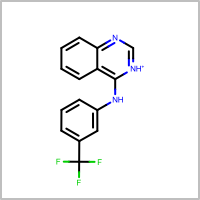

In [27]:
#for i, match in enumerate(mcss.Match(target, unique)):
oenb.draw_mol(m_list[0])